# Persoalan 6
Carilah data hasil panen atau penjualan produk yang sama, tetapi beda musim (misal hujan 
dan kemarau) lalu carilah relasi antara hasil panen atau penjualan produk dengan musim 
tersebut. Kemudian hitung juga performanya.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [13]:
# Step 1: Load Data
df = pd.read_csv('../dataset/AALI.JK_historical_data.csv', header=2)

df.columns = ["Date", "Adj Close", "Close", "High", "Low", "Open", "Volume"]

# Convert Date column to datetime format
df["Date"] = pd.to_datetime(df["Date"])

In [14]:
# Step 2: Set Date as Index and Resample Monthly
df.set_index("Date", inplace=True)
df_monthly = df.resample('M').mean()

/tmp/ipykernel_948349/2231641452.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').mean()


In [15]:
# Step 3: Add a season column
def get_season(date):
    if date.month in [11, 12, 1, 2, 3]:
        return "Hujan"
    elif date.month in [4, 5, 6, 7, 8, 9, 10]:
        return "Kemarau"

df_monthly["Season"] = df_monthly.index.map(get_season)


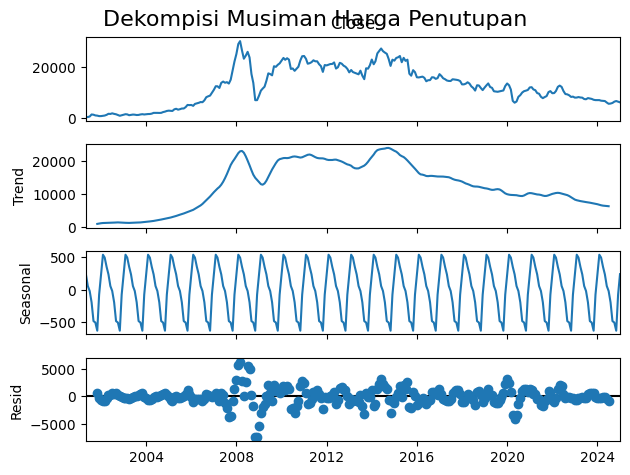

In [16]:
# Step 4: Decompose Time Series
result = seasonal_decompose(df_monthly["Close"], model="additive", period=12)


# Plot Decomposition
result.plot()
plt.suptitle("Dekompisi Musiman Harga Penutupan", fontsize=16)
plt.show()

In [17]:
# Step 5: Analyze Seasonal Differences
# Grouping data by season
seasonal_data = df_monthly.groupby("Season").agg({
    "Close": ["mean", "std"],
    "Volume": ["mean", "std"]
}).reset_index()

# Flatten MultiIndex columns for clarity
seasonal_data.columns = ["Season", "Close_Mean", "Close_Std", "Volume_Mean", "Volume_Std"]


In [18]:
# Step 6: Perform T-Test for Significance
rainy = df_monthly[df_monthly["Season"] == "Hujan"]["Close"].dropna()
dry = df_monthly[df_monthly["Season"] == "Kemarau"]["Close"].dropna()

stat, p_value = ttest_ind(rainy, dry, equal_var=False)

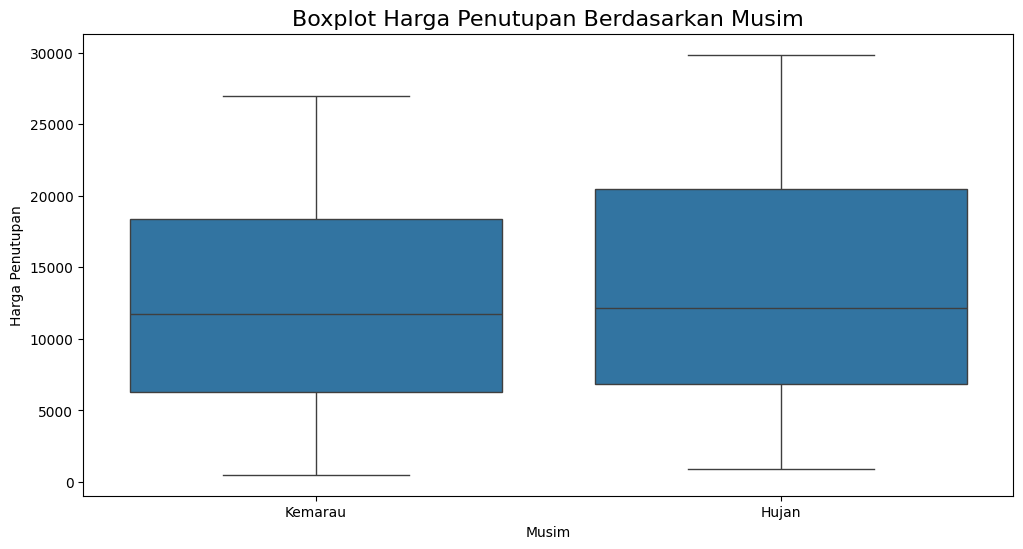

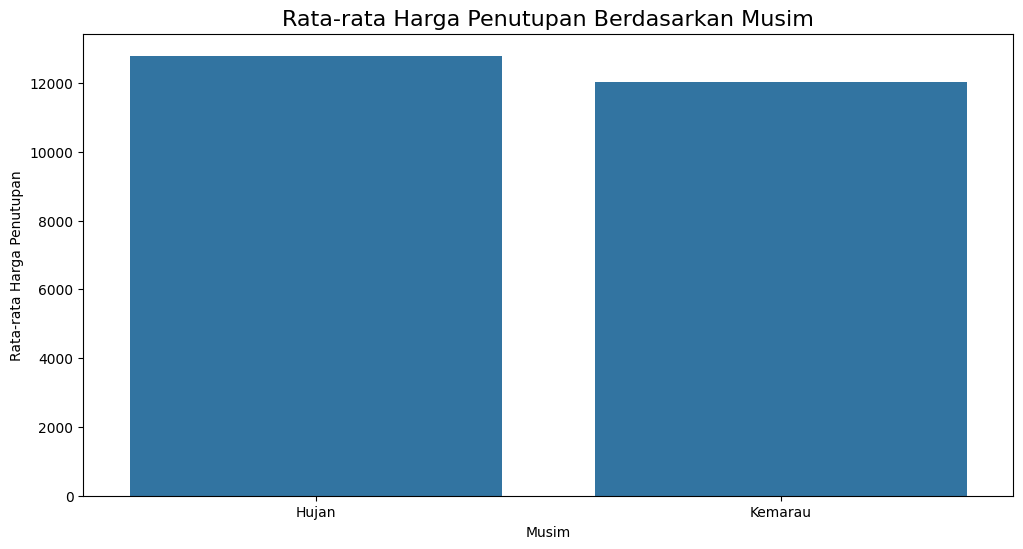

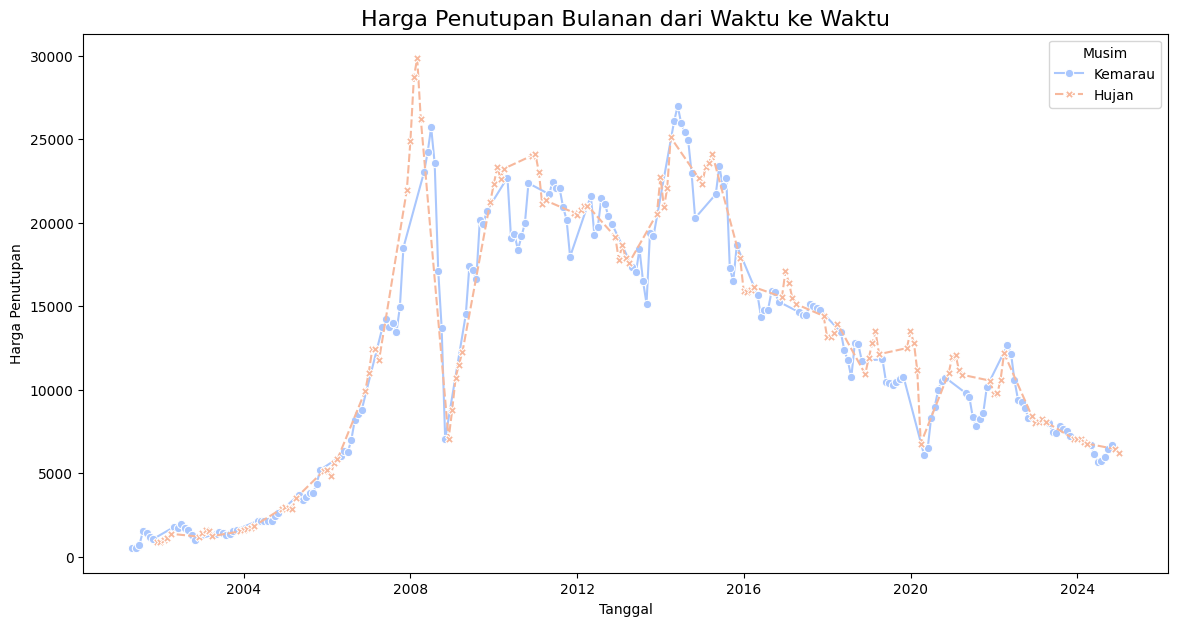

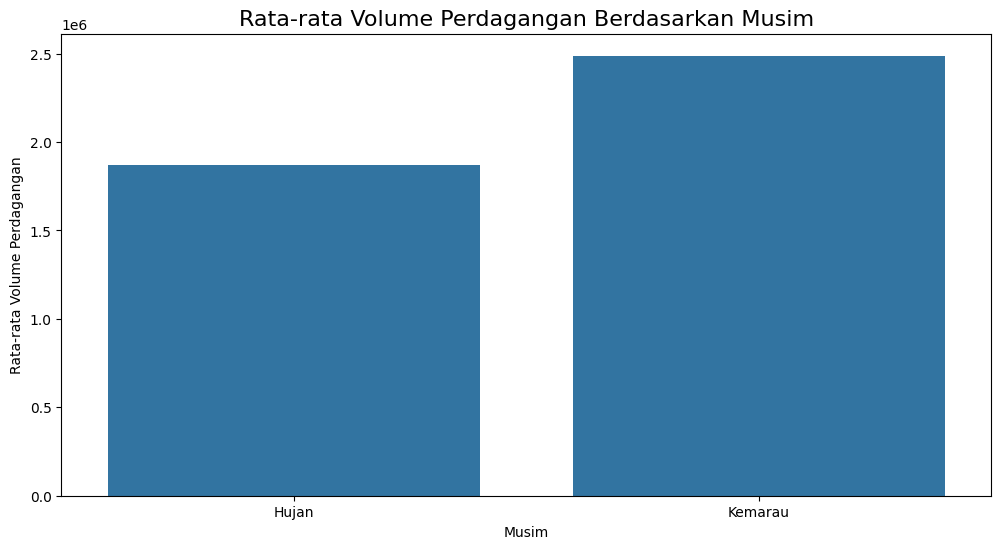

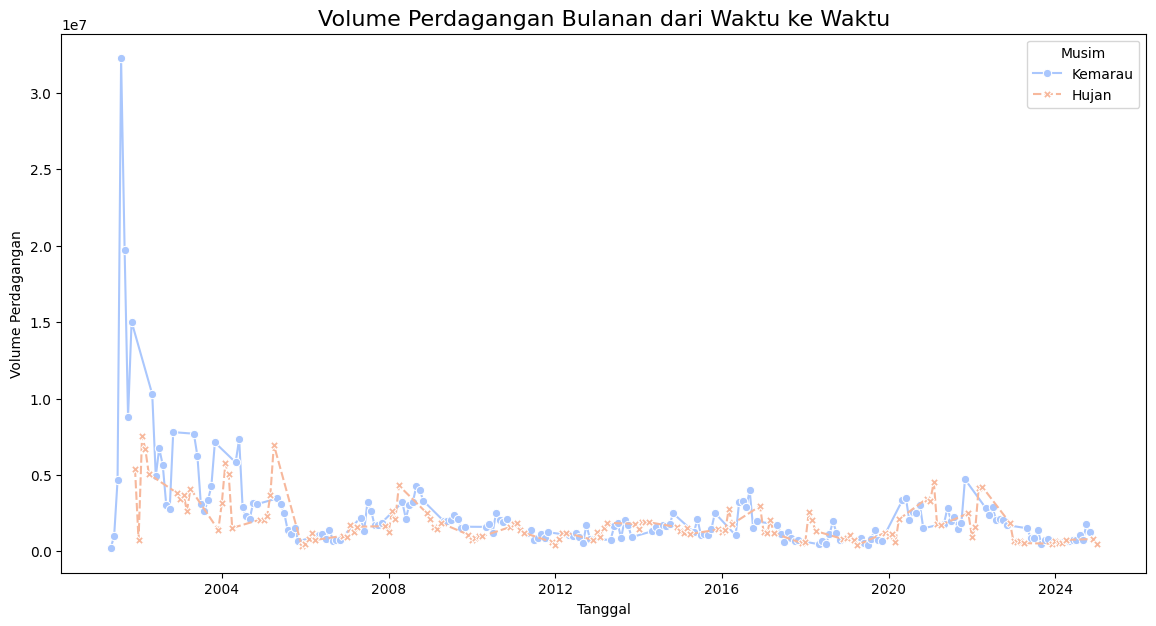

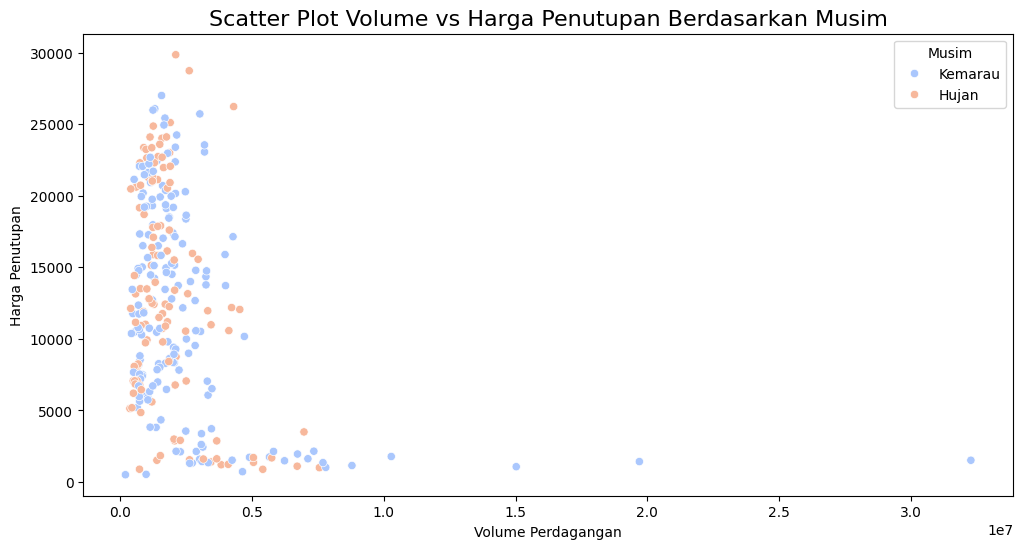

In [19]:
# Step 7: Enhanced Visualizations
# Boxplot for Closing Prices
plt.figure(figsize=(12, 6))
sns.boxplot(x="Season", y="Close", data=df_monthly)
plt.title("Boxplot Harga Penutupan Berdasarkan Musim", fontsize=16)
plt.ylabel("Harga Penutupan")
plt.xlabel("Musim")
plt.show()

# Barplot for Average Closing Prices
plt.figure(figsize=(12, 6))
sns.barplot(x="Season", y="Close_Mean", data=seasonal_data, errorbar=None)
plt.title("Rata-rata Harga Penutupan Berdasarkan Musim", fontsize=16)
plt.ylabel("Rata-rata Harga Penutupan")
plt.xlabel("Musim")
plt.show()

# Line plot for Closing Prices Over Time
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_monthly, x=df_monthly.index, y="Close", hue="Season", style="Season", markers=True, palette="coolwarm")
plt.title("Harga Penutupan Bulanan dari Waktu ke Waktu", fontsize=16)
plt.ylabel("Harga Penutupan")
plt.xlabel("Tanggal")
plt.legend(title="Musim")
plt.show()

# Volume Analysis: Barplot for Average Volume by Season
plt.figure(figsize=(12, 6))
sns.barplot(x="Season", y="Volume_Mean", data=seasonal_data, errorbar=None)
plt.title("Rata-rata Volume Perdagangan Berdasarkan Musim", fontsize=16)
plt.ylabel("Rata-rata Volume Perdagangan")
plt.xlabel("Musim")
plt.show()

# Line plot for Volume Over Time
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_monthly, x=df_monthly.index, y="Volume", hue="Season", style="Season", markers=True, palette="coolwarm")
plt.title("Volume Perdagangan Bulanan dari Waktu ke Waktu", fontsize=16)
plt.ylabel("Volume Perdagangan")
plt.xlabel("Tanggal")
plt.legend(title="Musim")
plt.show()

# Scatter plot for Close vs Volume with Season
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_monthly, x="Volume", y="Close", hue="Season", palette="coolwarm")
plt.title("Scatter Plot Volume vs Harga Penutupan Berdasarkan Musim", fontsize=16)
plt.ylabel("Harga Penutupan")
plt.xlabel("Volume Perdagangan")
plt.legend(title="Musim")
plt.show()

In [20]:
# Step 8: Calculate R-squared Value
# Encoding season for regression
season_mapping = {"Hujan": 0, "Kemarau": 1}
df_monthly["Season_Encoded"] = df_monthly["Season"].map(season_mapping)

# Linear regression for Close prices based on Season
X = df_monthly["Season_Encoded"].dropna().values.reshape(-1, 1)
y = df_monthly["Close"].dropna()

reg_model = LinearRegression()
reg_model.fit(X, y)

y_pred = reg_model.predict(X)
r_squared = r2_score(y, y_pred)

print(f"Nilai R-squared untuk Musim vs Harga Penutupan: {r_squared:.4f}")

# Additional Regression Insights
print("Koefisien Regresi:")
print(f"Intercept: {reg_model.intercept_:.2f}, Slope: {reg_model.coef_[0]:.2f}")

Nilai R-squared untuk Musim vs Harga Penutupan: 0.0026
Koefisien Regresi:
Intercept: 12793.05, Slope: -774.00


In [21]:
# Step 9: Interpretation of Results
print("Hasil Uji T:")
print(f"Statistik: {stat:.2f}, P-Value: {p_value:.5f}")
if p_value < 0.05:
    print("\nPerbedaan harga penutupan antara musim memiliki signifikansi statistik.")
else:
    print("\nTidak ada perbedaan harga penutupan yang signifikan secara statistik antara musim.")

Hasil Uji T:
Statistik: 0.86, P-Value: 0.39233

Tidak ada perbedaan harga penutupan yang signifikan secara statistik antara musim.


In [22]:
# Step 10: Summary of Findings
print("\nRingkasan Temuan:")
print(f"Nilai R-squared menunjukkan bahwa {r_squared*100:.2f}% variansi dalam harga penutupan dijelaskan oleh musim.")
if p_value < 0.05:
    print("Musim memiliki pengaruh yang signifikan secara statistik terhadap harga penutupan.")
else:
    print("Musim tidak memiliki pengaruh yang signifikan secara statistik terhadap harga penutupan.")



Ringkasan Temuan:
Nilai R-squared menunjukkan bahwa 0.26% variansi dalam harga penutupan dijelaskan oleh musim.
Musim tidak memiliki pengaruh yang signifikan secara statistik terhadap harga penutupan.
